#### Import important libraries

In [8]:
import pandas as pd
import gensim
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gensim
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Phrases
from gensim.models.phrases import Phraser

#### Load and Explore the Dataset

In [10]:
# Load the dataset
df_dataset = pd.read_csv('IMDB Dataset.csv')

# Check dataframe
df_dataset

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [12]:
# Count of each sentiment to be sure they are balanced
df_dataset['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

#### Text Preprocessing

In [17]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Remove special characters and lowercase

def clean_text(text):
     # remove HTML
    text = re.sub(r'<.*?>', '', text) 
     # remove punctuation/numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    return text.lower()

df_dataset['clean_review'] = df_dataset['review'].apply(clean_text)

In [16]:
df_dataset

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,im going to have to disagree with the previous...


#### Tokenisation

In [18]:
def tokenize(text):
    # deacc = False because we have already removed punctuation
    return simple_preprocess(text, deacc = False)

df_dataset['tokens'] = df_dataset['clean_review'].apply(tokenize)

In [19]:
# Show tokenized reviews (unigrams)
df_dataset[['clean_review', 'tokens']]

,clean_review,tokens
0,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewers, has, mentione..."
1,a wonderful little production the filming tech...,"[wonderful, little, production, the, filming, ..."
2,i thought this was a wonderful way to spend ti...,"[thought, this, was, wonderful, way, to, spend..."
3,basically theres a family where a little boy j...,"[basically, theres, family, where, little, boy..."
4,petter matteis love in the time of money is a ...,"[petter, matteis, love, in, the, time, of, mon..."
...,...,...
49995,i thought this movie did a down right good job...,"[thought, this, movie, did, down, right, good,..."
49996,bad plot bad dialogue bad acting idiotic direc...,"[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,i am a catholic taught in parochial elementary...,"[am, catholic, taught, in, parochial, elementa..."
49998,im going to have to disagree with the previous...,"[im, going, to, have, to, disagree, with, the,..."


In [22]:
# Build bigram and trigram models
bigram = Phrases(df_dataset['tokens'], min_count=5, threshold=100)
trigram = Phrases(bigram[df_dataset['tokens']], threshold=100)

# Convert them to efficient phrasers
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Apply the models
df_dataset['bigrams'] = df_dataset['tokens'].apply(lambda x: bigram_mod[x])
df_dataset['trigrams'] = df_dataset['bigrams'].apply(lambda x: trigram_mod[x])

In [23]:
# Show bigram tokens (contain exactly one underscore)
for i in range(10):
    bigrams_only = [token for token in df_dataset['bigrams'][i] if token.count('_') == 1]
    if bigrams_only:
        print(f"Review {i+1} bigrams only:", bigrams_only)

Review 1 bigrams only: ['maximum_security', 'graphic_violence', 'middle_class', 'darker_side']
Review 3 bigrams only: ['serial_killer', 'woody_allen', 'wears_prada']
Review 4 bigrams only: ['soap_opera']
Review 5 bigrams only: ['visually_stunning', 'new_york', 'steve_buscemi', 'rosario_dawson', 'carol_kane', 'michael_imperioli']
Review 6 bigrams only: ['alltime_favorite', 'paul_lukas', 'bette_davis', 'whats_happening']
Review 8 bigrams only: ['mildly_entertaining']
Review 9 bigrams only: ['looking_forward', 'harvey_keitel']
Review 10 bigrams only: ['gut_wrenching']


In [26]:
# Show trigram tokens (contain exactly two underscores)
for i in range(10):
    trigrams_only = [token for token in df_dataset['trigrams'][i] if token.count('_') == 2]
    if trigrams_only:
        print(f"Review {i+1} trigrams only:", trigrams_only)

Review 3 trigrams only: ['devil_wears_prada']


In [28]:
# Remove stopwords (with custom domain stopwords like “br”, “film”, “movie”)

# Convert to mutable set so we can add custom words
my_stopwords = set(STOPWORDS)

# Add domain-specific stopwords
my_stopwords.update(['br', 'film', 'movie'])

# Define function to remove them
def remove_custom_stopwords(tokens):
    return [token for token in tokens if token not in my_stopwords]

# Apply to trigrams column
df_dataset['trigrams_nostop'] = df_dataset['trigrams'].apply(remove_custom_stopwords)

# Preview a few
df_dataset['trigrams_nostop'].head()

0    [reviewers, mentioned, watching, oz, episode, ...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, theres, family, little, boy, jake,...
4    [petter, matteis, love, time, money, visually_...
Name: trigrams_nostop, dtype: object

#### Lemmatization using spaCy (only nouns, adjectives, verbs, adverbs)

In [30]:
!pip install spacy

  Using cached numpy-2.2.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp312-cp312-macosx_14_0_arm64.whl (5.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.


In [36]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.6 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [41]:
# Load the model
import spacy
nlp = spacy.load('en_core_web_sm')

In [49]:
#  Define the lemmatiser function

# Meaningful parts of speech
allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']  

def lemmatise_spacy(tokens):
     # Combine token list into string
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

# Apply to stopword-cleaned trigrams

df_dataset['final_tokens'] = df_dataset['trigrams_nostop'].apply(lemmatise_spacy)

print(df_dataset['final_tokens'][0])

['reviewer', 'mention', 'watch', 'episode', 'hook', 'right', 'exactly', 'happen', 'methe', 'thing', 'strike', 'brutality', 'unflinche', 'scene', 'violence', 'set', 'right', 'word', 'trust', 'faint', 'hearted', 'timid', 'pull', 'punch', 'regard', 'drug', 'sex', 'violence', 'hardcore', 'classic', 'use', 'wordit', 'call', 'nickname', 'give', 'state', 'focus', 'mainly', 'section', 'prison', 'cell', 'glass', 'front', 'face', 'inward', 'privacy', 'high', 'agenda', 'city', 'home', 'manyaryan', 'muslim', 'irish', 'moreso', 'scuffle', 'death', 'stare', 'dodgy', 'dealing', 'shady', 'agreement', 'far', 'awayi', 'main', 'appeal', 'fact', 'go', 'show', 'dare', 'forget', 'pretty', 'picture', 'paint', 'mainstream', 'audience', 'forget', 'charm', 'forget', 'romanceoz', 'mess', 'episode', 'see', 'strike', 'nasty', 'surreal', 'ready', 'watch', 'develop', 'taste', 'get', 'accustomed', 'high', 'level', 'graphic_violence', 'violence', 'injustice', 'crook', 'guard', 'sell', 'nickel', 'inmate', 'kill', 'orde

#### Frequency and Word Cloud Visualisation

In [58]:
!pip install wordcloud

In [60]:
from wordcloud import WordCloud

# Join all tokens into one string for word cloud generation
all_words = ' '.join([' '.join(tokens) for tokens in df_dataset['final_tokens']])

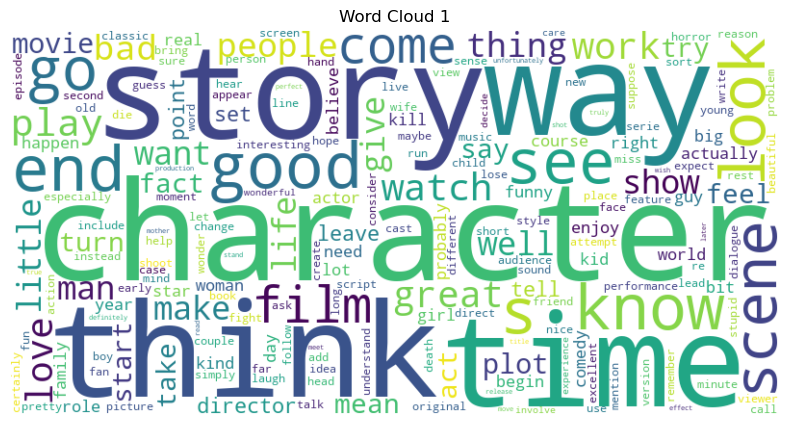

In [62]:
# Generate and display the first word cloud

# Word cloud 1
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud 1")
plt.show()

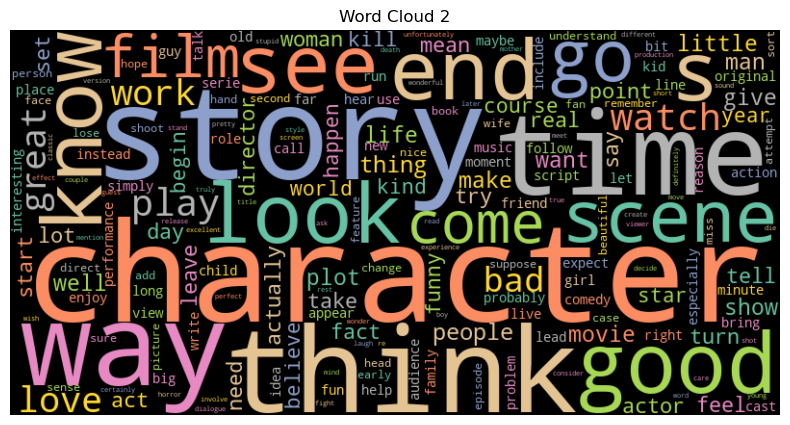

In [64]:
# Generate and display a second one with a different configuration for comparison

# Word cloud 2
wordcloud2 = WordCloud(width=800, height=400, background_color='black', colormap='Set2').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud 2")
plt.show()

#### Convert tokens into features using TF-IDF next

We need to join them into full sentences because TfidfVectorizer expects strings.

In [78]:
df_dataset['final_text'] = df_dataset['final_tokens'].apply(lambda tokens: ' '.join(tokens))

In [80]:
# Import and initialize the TF-IDF Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000) 

In [82]:
# Fit and transform text to create feature matrix
X_tfidf = tfidf_vectorizer.fit_transform(df_dataset['final_text'])

In [83]:
# Prepare the labels (target values) converting the sentiment column to 0s and 1s for model training
y = df_dataset['sentiment'].map({'positive': 1, 'negative': 0})

In [86]:
# Train/test split
from sklearn.model_selection import train_test_split

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [88]:
print(X_train_tfidf)

  (0, 2017)	0.062424773439715024
  (0, 1902)	0.05381741786326764
  (0, 1098)	0.07375270080670299
  (0, 289)	0.06887595648715937
  (0, 2891)	0.10441219341172395
  (0, 1889)	0.04943545887713533
  (0, 2469)	0.07388829070781981
  (0, 2569)	0.05197197181360365
  (0, 3618)	0.08682334905530352
  (0, 4498)	0.04307027038183638
  (0, 4525)	0.03826477153869715
  (0, 3250)	0.051236528334422604
  (0, 1206)	0.07597282192720828
  (0, 675)	0.04152296790447346
  (0, 2693)	0.09975152240376868
  (0, 2232)	0.1039779561081084
  (0, 2657)	0.07903092906488615
  (0, 2204)	0.08870718750869158
  (0, 1815)	0.06439989957690459
  (0, 1689)	0.07701040847205415
  (0, 1321)	0.07864601659728243
  (0, 4182)	0.09841789427994119
  (0, 1215)	0.06931089085951597
  (0, 1234)	0.1167912933556419
  (0, 2458)	0.045999257507269804
  :	:
  (39999, 45)	0.12344067213105078
  (39999, 3095)	0.16838606388900998
  (39999, 4260)	0.1415686771023891
  (39999, 2414)	0.10732873242442718
  (39999, 2114)	0.12118040775440306
  (39999, 1230)	0.

The word with index 2017 in the vocabulary appeared in review 0. And its importance score is 0.062, based on how frequent it is in that review and how rare it is overall

### Training my first traditional ML model (Simple Logistic Regression Classifier)

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train the model
lr_model = LogisticRegression(max_iter = 1000)
lr_model.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



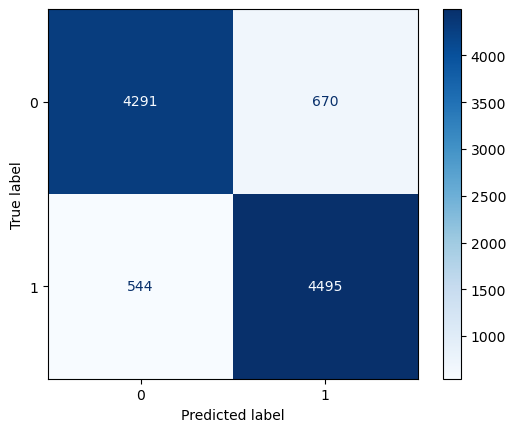

In [98]:
# Confusion Matrix 
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lr_model.classes_)
disp.plot(cmap='Blues')

0 = negative, 1 = positive

### Training my second Traditional ML model ( Multinomial Naive Bayes)

In [100]:
from sklearn.naive_bayes import MultinomialNB

# Train the model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test_tfidf)

# Evaluate
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4961
           1       0.85      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



Comparison of the traditional models shows: Logistic Regression had an accuracy of 0.88, and F1 score(avg) of 0.88.

While Naive Bayes had a 0.85 accuracy and 0.85 F1 score. This indicates that Logistic regression is slightly better, but both are working well.

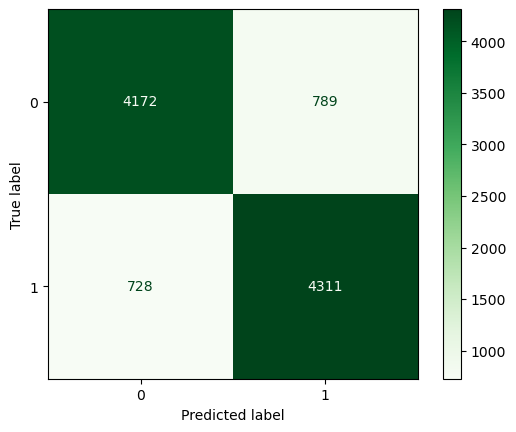

In [102]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot(cmap='Greens')

#### Building my first deep learning model (Feedforward Neural Network (MLP) using Keras.

In [105]:
# Import Keras libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [107]:
# Build model
mlp_model = Sequential()
mlp_model.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
# To prevent overfitting
mlp_model.add(Dropout(0.3))  
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dropout(0.3))
# Output layer for binary classification
mlp_model.add(Dense(1, activation='sigmoid'))  
mlp_model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,449 (2.47 MB)

 Trainable params: 648,449 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
# Compile model
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [111]:
# Train the model

history = mlp_model.fit(X_train_tfidf.toarray(), y_train, epochs=10, batch_size=128, 
                        validation_split=0.2,verbose=1)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7344 - loss: 0.5092 - val_accuracy: 0.8735 - val_loss: 0.2981
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9042 - loss: 0.2443 - val_accuracy: 0.8709 - val_loss: 0.3048
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9241 - loss: 0.2048 - val_accuracy: 0.8684 - val_loss: 0.3151
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9422 - loss: 0.1643 - val_accuracy: 0.8624 - val_loss: 0.3507
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9642 - loss: 0.1172 - val_accuracy: 0.8611 - val_loss: 0.4010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9814 - loss: 0.0691 - val_accuracy: 0.8565 - val_loss: 0.4503
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9894 - loss: 0.0409 - val_accuracy: 0.8576 - val_loss: 0.5376
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9941 - loss: 0.0228 - val_accuracy: 0.

In [113]:
# Evaluation the model on the test set

# Predict on test set
y_pred_prob = mlp_model.predict(X_test_tfidf.toarray())
y_pred = (y_pred_prob > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      4961
           1       0.87      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



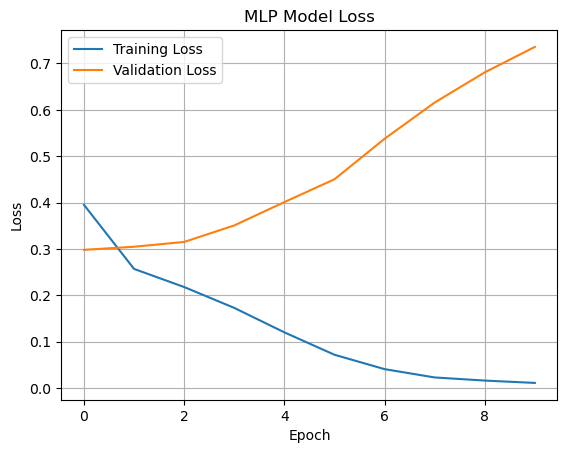

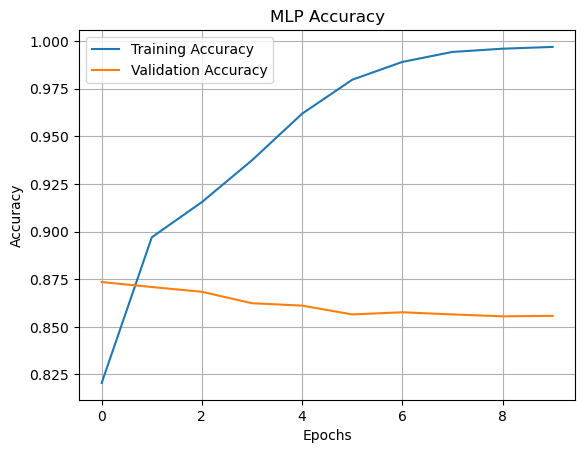

In [115]:
# Plot Accuracy and loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step


<Figure size 600x600 with 0 Axes>

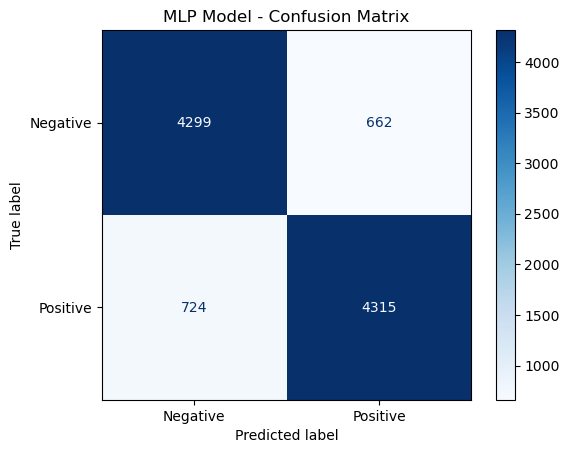

In [117]:
# Visualisation for confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for test set
y_pred_prob = mlp_model.predict(X_test_tfidf.toarray())
# Convert probabilities to binary (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)  

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =['Negative', 'Positive'])

# Plot it
plt.figure(figsize =(6, 6))
disp.plot(cmap ='Blues', values_format ='d')
plt.title('MLP Model - Confusion Matrix')
plt.grid(False)
plt.show()

#### Build next deep learning model (CNN)

In [126]:
X = df_dataset['final_tokens'].apply(lambda x: ' '.join(x))
y = df_dataset['sentiment'].map({'positive':1, 'negative':0})

In [128]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
# Tokenise and pad text

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Vocabulary size (number of unique words)
max_features = 10000
# Max length of each input sequence (padded)
maxlen = 200

# Tokenization
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [132]:
# Pad sequences to same length
X_train_pad = pad_sequences(X_train_seq, maxlen = maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen = maxlen)

In [134]:
# Convert labels to NumPy arrays
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [178]:
# Build the CNN model

from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim = max_features, output_dim = 128, input_length = maxlen))
cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation ='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='relu'))
# Binary classification
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.build(input_shape=(None, maxlen))
cnn_model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 196, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,370,369 (5.23 MB)

 Trainable params: 1,370,369 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

In [180]:
# Compile the CNN model
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [182]:
# Train the model

history_cnn = cnn_model.fit(X_train_pad, y_train_np, epochs=10, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6640 - loss: 0.5792 - val_accuracy: 0.8541 - val_loss: 0.3426
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8760 - loss: 0.2982 - val_accuracy: 0.8644 - val_loss: 0.3221
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9319 - loss: 0.1902 - val_accuracy: 0.8604 - val_loss: 0.3562
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9624 - loss: 0.1068 - val_accuracy: 0.8593 - val_loss: 0.4160
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9810 - loss: 0.0611 - val_accuracy: 0.8545 - val_loss: 0.5302
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9871 - loss: 0.0462 - val_accuracy: 0.8533 - val_loss: 0.6251
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9891 - loss: 0.0320 - val_accuracy: 0.8533 - val_loss: 0.7000
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9911 - loss: 0.0274 - 

In [184]:
# Evaluate the CNN on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test_pad, y_test_np)

print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8472 - loss: 0.8093
Test Accuracy: 0.8463000059127808
Test Loss: 0.8083299398422241


In [186]:
# Predict probabilities on the test set
cnn_probs = cnn_model.predict(X_test_pad)

# Convert probabilities to binary predictions (0 or 1)
cnn_preds = (cnn_probs > 0.5).astype("int32")

# Classification Report
print(classification_report(y_test_np, cnn_preds))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      4961
           1       0.86      0.83      0.84      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



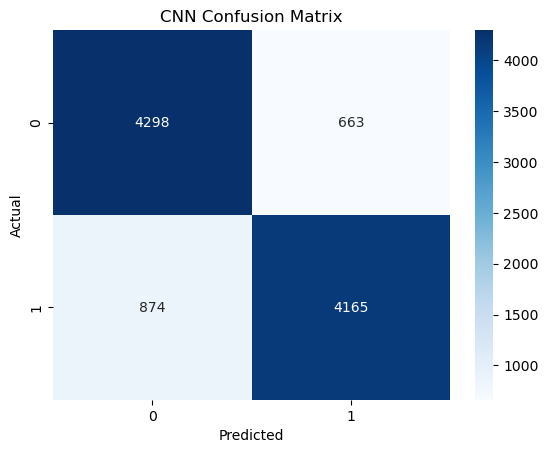

In [188]:
# Confusion Matrix
cm = confusion_matrix(y_test_np, cnn_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CNN Confusion Matrix")
plt.show()

1 = positive, 0 = negative

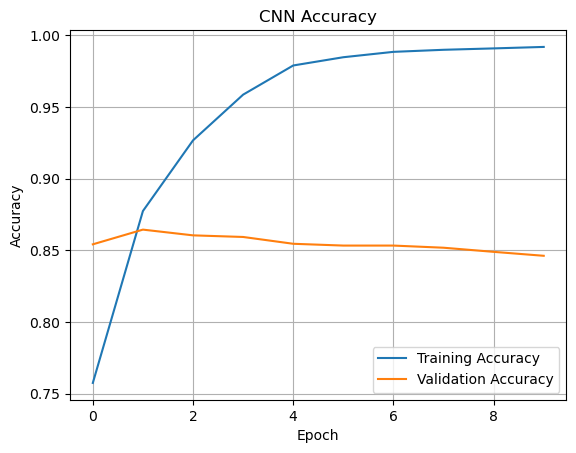

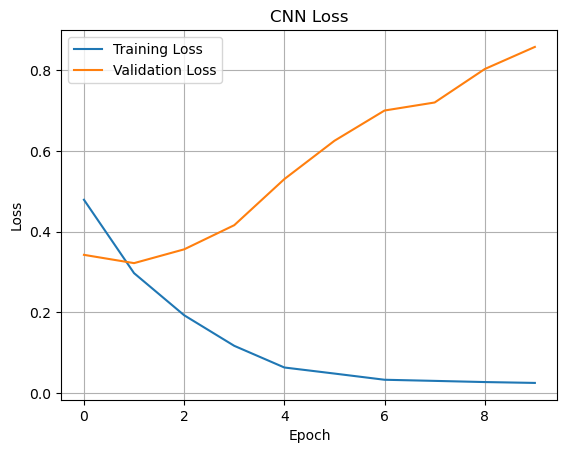

In [190]:
# Accuracy & Loss Plots

# Accuracy Plot
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Refining each method/model (hyperparameter tunning + L2 regularisation.

CNN model

In [280]:
from keras.regularizers import l2
from keras.optimizers import Adam

refined_cnn_model = Sequential()
refined_cnn_model.add(Embedding(input_dim= max_features, output_dim=128))
refined_cnn_model.add(Conv1D(filters= 64, kernel_size =3, activation='relu', kernel_regularizer=l2(0.001)))
refined_cnn_model.add(GlobalMaxPooling1D())
refined_cnn_model.add(Dropout(0.2))
refined_cnn_model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
refined_cnn_model.add(Dropout(0.2))
refined_cnn_model.add(Dense(1, activation='sigmoid'))

refined_cnn_model.build(input_shape=(None, maxlen))

In [282]:
# Summary
refined_cnn_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)        │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 198, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_12         │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,306,753 (4.98 MB)

 Trainable params: 1,306,753 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

In [284]:
# Compile with slightly lower learning rate
refined_cnn_model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [286]:
# Train refined model

history_refined_cnn = refined_cnn_model.fit(X_train_pad, y_train, epochs=10, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.6532 - loss: 0.6778 - val_accuracy: 0.8413 - val_loss: 0.4085
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8600 - loss: 0.3744 - val_accuracy: 0.8568 - val_loss: 0.3718
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9138 - loss: 0.2754 - val_accuracy: 0.8553 - val_loss: 0.3786
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9464 - loss: 0.1998 - val_accuracy: 0.8540 - val_loss: 0.4069
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9710 - loss: 0.1470 - val_accuracy: 0.8535 - val_loss: 0.4503
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9829 - loss: 0.1110 - val_accuracy: 0.8466 - val_loss: 0.5027
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9879 - loss: 0.0924 - val_accuracy: 0.8431 - val_loss: 0.5369
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9931 - loss: 0.0761 - val_accu

In [288]:
# Predict probabilities
refined_cnn_probs = refined_cnn_model.predict(X_test_pad)

# Convert to binary predictions
refined_cnn_preds = (refined_cnn_probs > 0.5).astype("int32")

# Classification Report
print(classification_report(y_test, refined_cnn_preds))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4961
           1       0.83      0.86      0.85      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



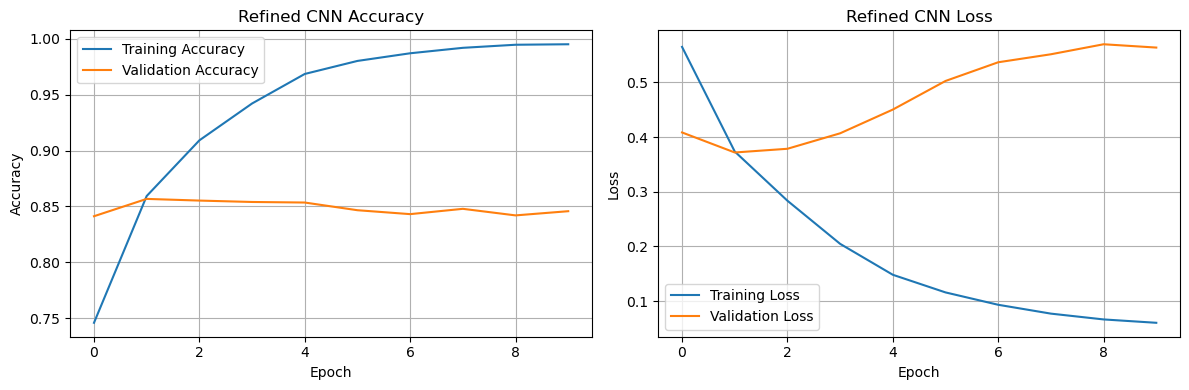

In [290]:
# Plot Accuracy and Loss Plots

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_refined_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_refined_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Refined CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_refined_cnn.history['loss'], label='Training Loss')
plt.plot(history_refined_cnn.history['val_loss'], label='Validation Loss')
plt.title('Refined CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

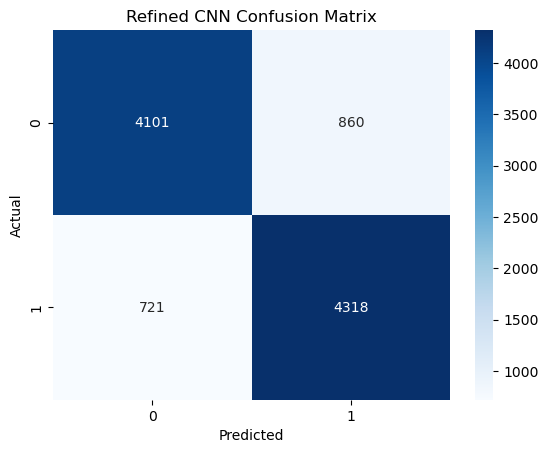

In [292]:
# Confusion Matrix
cm = confusion_matrix(y_test, refined_cnn_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Refined CNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

####  Refining the Feedforward Neural Network

In [318]:
# Build refined MLP model
refined_mlp_model = Sequential()
refined_mlp_model.add(Dense(256, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
# Increased dropout
refined_mlp_model.add(Dropout(0.5))  
refined_mlp_model.add(Dense(128, activation='relu'))
refined_mlp_model.add(Dropout(0.4))
refined_mlp_model.add(Dense(64, activation='relu'))
refined_mlp_model.add(Dropout(0.3))
refined_mlp_model.add(Dense(32, activation='relu'))
refined_mlp_model.add(Dropout(0.2))
refined_mlp_model.add(Dense(16, activation='relu'))
refined_mlp_model.add(Dense(1, activation='sigmoid'))

refined_mlp_model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_39 (Dense)                │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,324,033 (5.05 MB)

 Trainable params: 1,324,033 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

In [320]:
# Compile the model with Adam optimizer and a lower learning rate
refined_mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [322]:
# Train the refined model
refined_mlp_history = refined_mlp_model.fit(X_train_tfidf.toarray(), y_train, epochs=10, batch_size=128, 
                                            validation_split=0.2, verbose=1)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6992 - loss: 0.5375 - val_accuracy: 0.8720 - val_loss: 0.3034
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9035 - loss: 0.2521 - val_accuracy: 0.8683 - val_loss: 0.3094
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9333 - loss: 0.1850 - val_accuracy: 0.8669 - val_loss: 0.3395
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9606 - loss: 0.1151 - val_accuracy: 0.8633 - val_loss: 0.4066
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9785 - loss: 0.0684 - val_accuracy: 0.8633 - val_loss: 0.5141
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9849 - loss: 0.0440 - val_accuracy: 0.8600 - val_loss: 0.5783
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9893 - loss: 0.0329 - val_accuracy: 0.8576 - val_loss: 0.6031
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9905 - loss: 0.0310 - val_accuracy: 0

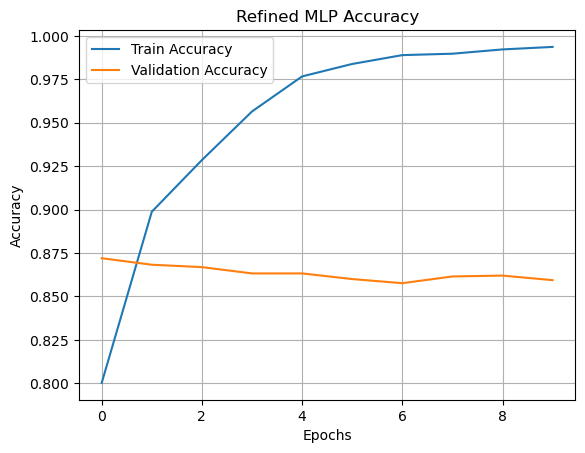

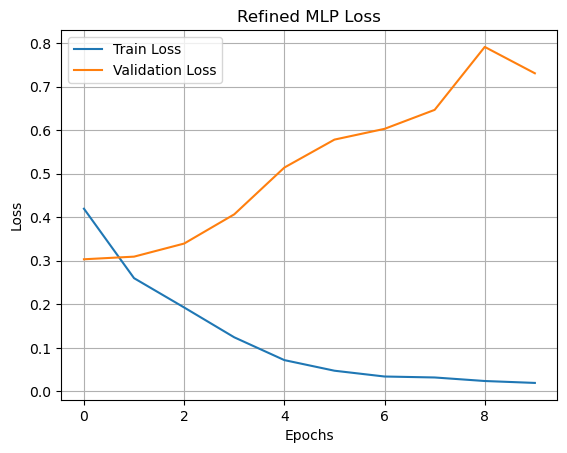

In [324]:
# Plot Accuracy and Loss

# Accuracy plot
plt.plot(refined_mlp_history.history['accuracy'], label='Train Accuracy')
plt.plot(refined_mlp_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Refined MLP Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(refined_mlp_history.history['loss'], label='Train Loss')
plt.plot(refined_mlp_history.history['val_loss'], label='Validation Loss')
plt.title('Refined MLP Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [326]:
# Predict probabilities
mlp_probs = refined_mlp_model.predict(X_test_tfidf.toarray())

# Convert probabilities to binary predictions (0 or 1)
mlp_preds = (mlp_probs > 0.5).astype("int32")

print(classification_report(y_test, mlp_preds, target_names=["Negative", "Positive"]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      4961
    Positive       0.87      0.86      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



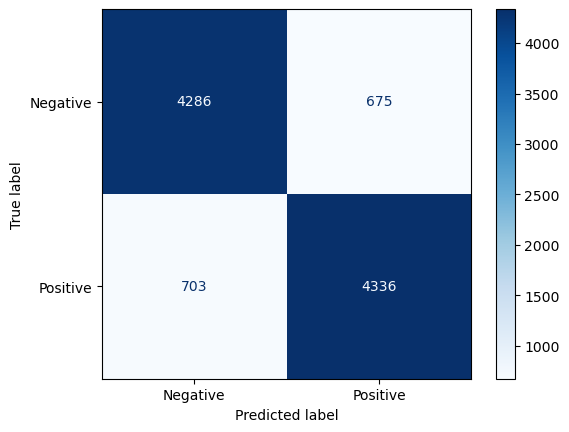

In [328]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, mlp_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')

### Refining the Traditional models

In [ ]:
# For Multinomial Naive Bayes: We’ll tune the alpha parameter (Laplace smoothing)

In [330]:
from sklearn.model_selection import GridSearchCV

# Grid search for alpha
nb_params = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
nb_grid = GridSearchCV(MultinomialNB(), nb_params, cv=5, scoring='f1')
nb_grid.fit(X_train_tfidf, y_train)

# Best model
refined_nb_model = nb_grid.best_estimator_
print("Best alpha:", nb_grid.best_params_['alpha'])

Best alpha: 2.0


In [332]:
# Evaluate the Refined Multinomial Naive Bayes

# Predict
nb_preds = refined_nb_model.predict(X_test_tfidf)

# Classification Report
print("Refined Multinomial Naive Bayes")
print(classification_report(y_test, nb_preds))

Refined Multinomial Naive Bayes
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4961
           1       0.85      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



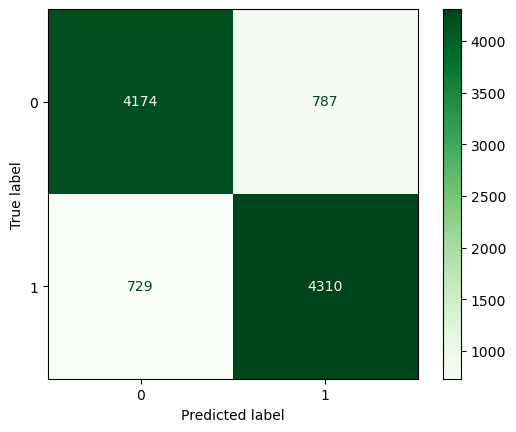

In [334]:
# Confusion Matrix

# Confusion Matrix
cm_nb = confusion_matrix(y_test, nb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=refined_nb_model.classes_)
disp.plot(cmap='Greens')

In [336]:
# Refining for Logistic Regression

# Grid search for C
lr_params = {'C': [0.01, 0.1, 1, 10]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, scoring='f1')
lr_grid.fit(X_train_tfidf, y_train)

# Best model
refined_lr_model = lr_grid.best_estimator_
print("Best C:", lr_grid.best_params_['C'])

Best C: 1


In [338]:
# Evaluate

# Predict
lr_preds = refined_lr_model.predict(X_test_tfidf)

# Classification Report
print("Refined Logistic Regression")
print(classification_report(y_test, lr_preds))

Refined Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



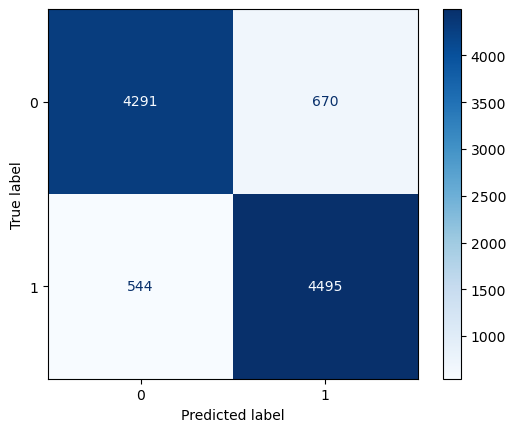

In [342]:
# Confusion Matrix 
cm_lr = confusion_matrix(y_test, lr_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_lr, display_labels = refined_lr_model.classes_)
disp.plot(cmap='Blues')

0 = negative, 1 = positive

#### Refine Logistic Regression model using PolynomialFeatures to capture interactions and non-linear patterns in the TF-IDF data

In [344]:
# import librabries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [346]:
# Create pipeline with polynomial features and logistic regression    # Less memory than full degree-2
poly_logreg_model = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                              ('logreg', LogisticRegression(C=1.0, max_iter=1000))])

In [348]:
# Fit the model
poly_logreg_model.fit(X_train_tfidf, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(interaction_only=True)),
                ('logreg', LogisticRegression(max_iter=1000))])

In [350]:
# Predict and evaluate
poly_preds = poly_logreg_model.predict(X_test_tfidf)

# classification report
print("Polynomial Logistic Regression Results")
print(classification_report(y_test, poly_preds))

Polynomial Logistic Regression Results
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      4961
           1       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



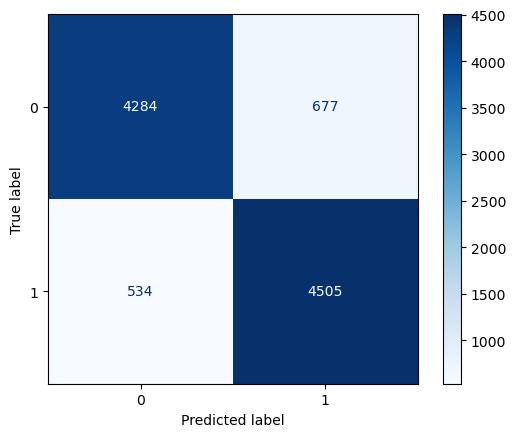

In [352]:
# Confusion matrix

cm_py = confusion_matrix(y_test, poly_preds)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_py, display_labels = poly_logreg_model.classes_)
disp.plot(cmap='Blues')

### PR-AUC Curve, ROC-AUC Curve For Logistic Regression Traditional ML

In [378]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Predict probabilities for the positive class 
# ( Because ROC-AUC and PR-AUC are typically computed with respect to the positive class. that’s class 1
lr_probs = lr_model.predict_proba(X_test_tfidf)[:, 1]

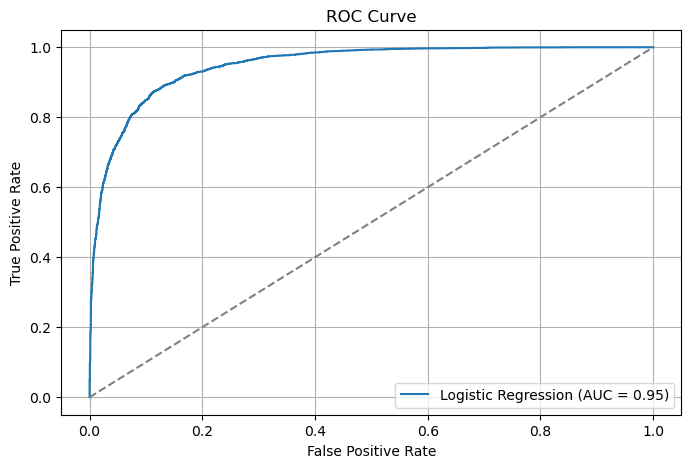

In [381]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc ='lower right')
plt.grid(True)
plt.show()

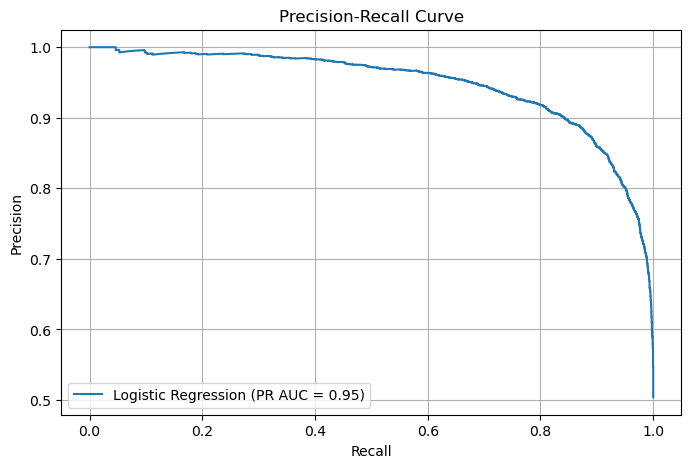

In [383]:
# Precision-Recall Curve

precision, recall, _ = precision_recall_curve(y_test, lr_probs)
pr_auc = average_precision_score(y_test, lr_probs)

plt.figure(figsize = (8, 5))
plt.plot(recall, precision, label =f'Logistic Regression (PR AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc ='lower left')
plt.grid(True)
plt.show()

### ROC-AUC and PR-AUC curves for MLP (Feedforward Neural Network) model

In [387]:
# Returns probabilities
mlp_probs = mlp_model.predict(X_test_tfidf.toarray())

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


#### ROC-AUC Curve

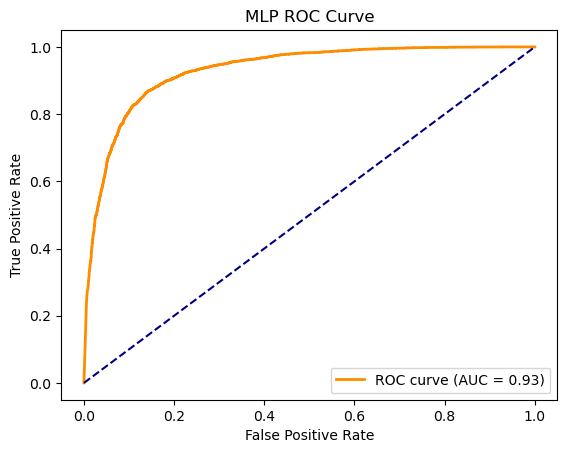

In [389]:
fpr, tpr, _ = roc_curve(y_test, mlp_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color ='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color ='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP ROC Curve')
plt.legend(loc ="lower right")
plt.show()

#### PR-AUC Curve

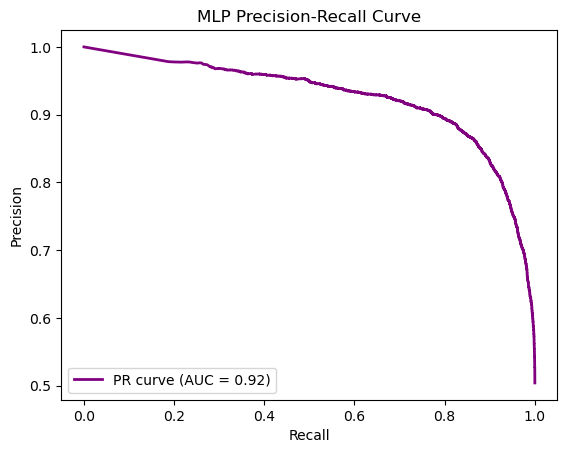

In [391]:
precision, recall, _ = precision_recall_curve(y_test, mlp_probs)
pr_auc = average_precision_score(y_test, mlp_probs)

plt.figure()
plt.plot(recall, precision, color ='purple', lw =2, label =f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('MLP Precision-Recall Curve')
plt.legend(loc ="lower left")
plt.show()